In [60]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from keras.utils import to_categorical
from sklearn.model_selection import validation_curve
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV

from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Embedding,LSTM,Dense
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.feature_extraction import text
import os
from sklearn.metrics import accuracy_score


In [61]:
print(os.listdir())

['.DS_Store', '.ipynb_checkpoints', 'AI Readmission _V3HYEljamaa.ipynb', 'amazon_cells_labelled.txt', 'imdb_labelled.txt', 'readme.txt', 'RiskAssessment.ipynb', 'sentiment analysis.ipynb', 'yelp_labelled.txt']


In [62]:
filepath_dict = {'yelp':   'yelp_labelled.txt',
                 'amazon': 'amazon_cells_labelled.txt',
                 'imdb':   'imdb_labelled.txt'}

In [63]:
#read sentences and its label from 3 text  filepath_dict
df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

In [64]:
len(df_list)

3

In [65]:
df = pd.concat(df_list)    # concat our files into one data frame

In [66]:
len(df)

2748

In [67]:
df['label'].value_counts()   # count our positve & negative lables and its density

1    1386
0    1362
Name: label, dtype: int64

In [68]:
df.head()

,sentence,label,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp


**Steps for Text preprocessing:**

**1.Remove Noisy Data.**

**2.Break each comment into sentences.**

**3.Tokenize or break each sentence into words**

**4.Transform words into vectors: -**

  - There are many methods to convert words into vectors as following: -
   - Bag of words (BoW)
   - TF-IDF
   - Word2Vec
      1.	Continuous Bag-of-Words Model
      2.	Continuous Skip-gram Model. 
   - Glove

***We can consider the last three methods [TF-IDF, Word2Vec & Glove] as word embedding which defined as a vector representations of a particular word. BoW introduced limitations such as large feature dimension, sparse representation***


In [69]:
X=df['sentence']
y=df['label']

In [70]:
X=list(X)

In [71]:
def remove_stopwords(data):
    output_array=[]
    for sentence in data:
        temp_list=[]
        for word in sentence.split():
            if word.lower() not in stopwords:
                temp_list.append(word)
        output_array.append(' '.join(temp_list))
    return output_array

In [72]:
stopwords=set(stopwords.words('english'))
output=remove_stopwords(X)

In [74]:
X[3]  #Before remve stop words

'Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.'

In [75]:
output[3]   # After remove stop words

'Stopped late May bank holiday Rick Steve recommendation loved it.'

**Here we create a class from Tokenizer for splitting a text into a list of tokens and token as parts like a word.here supposed the number of words les than 10000 with normalize our words**

In [78]:
tok=Tokenizer(lower=True,num_words=10000) 
tok.fit_on_texts(output)
seqs=tok.texts_to_sequences(X)
padded_seqs=pad_sequences(seqs,maxlen=100)   #badding to unique size 

In [79]:
seqs[0]

[569, 128, 120, 12]

In [80]:
padded_seqs[0]  # with 100 length

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0, 569, 128, 120,  12])

In [81]:
#Split our data into training and test data
y1=pd.DataFrame(y)
y_label=np.array(y1)
X_train,X_test,y_train,y_test=train_test_split(padded_seqs,y_label,train_size=0.85,test_size=0.15,random_state=43)

**Build our deep learning model with simple architecture with embedding Layer with input size 100 and 1 node as ouput with sigmoid activation function**

In [82]:
def createLSTM():
    model=Sequential()
    model.add(Embedding(10000,100)) 
    model.add(LSTM(256))
    model.add(Dense(100,activation='sigmoid'))
    model.add(Dense(1,activation='sigmoid'))
    return model

In [83]:
model=createLSTM()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               25700     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 1,391,369
Trainable params: 1,391,369
Non-trainable params: 0
_________________________________________________________________


In [85]:
np.shape(X_train),np.shape(y_train)


((2335, 100), (2335, 1))

**Compile our model:**

**The loss function binary crossentropy is used only 2 labels yes/no decisions or 1/0, it is a sigmoid activation in the last (output) layer and it's output is a probability value take range from 0 to 1 in almost cases if the prediction more than 0.5 so the class is 1 otherwise will be 0 and Adam algorithm as optimizer**

In [86]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
history=model.fit(X_train,y_train,batch_size=10,validation_data=(X_test,y_test),epochs=5,verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 2335 samples, validate on 413 samples
Epoch 1/5
2335/2335 [==============================] - 77s 33ms/step - loss: 0.6129 - acc: 0.6578 - val_loss: 0.4477 - val_acc: 0.8063
Epoch 2/5
2335/2335 [==============================] - 76s 33ms/step - loss: 0.2818 - acc: 0.8861 - val_loss: 0.4605 - val_acc: 0.7990
Epoch 3/5
2335/2335 [==============================] - 80s 34ms/step - loss: 0.1099 - acc: 0.9610 - val_loss: 0.6146 - val_acc: 0.7869
Epoch 4/5
2335/2335 [==============================] - 81s 35ms/step - loss: 0.0547 - acc: 0.9807 - val_loss: 0.6032 - val_acc: 0.7845
Epoch 5/5
2335/2335 [==============================] - 79s 34ms/step - loss: 0.0330 - acc: 0.9923 - val_loss: 0.8514 - val_acc: 0.7700


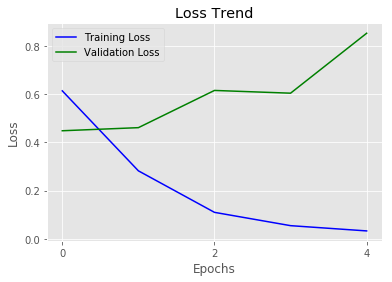

In [87]:
#plot the loss curve training and validation data against epochs
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,5)[0::2])
plt.legend()
plt.show()

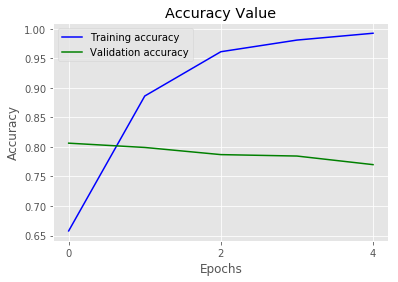

In [89]:
#plot the Accuracy curve training and validation data against epochs
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Value')
plt.plot(acc, 'blue', label='Training accuracy')
plt.plot(val_acc, 'green', label='Validation accuracy')
plt.xticks(range(0,5)[0::2])
plt.legend()
plt.show()

In [91]:
#Validate our model
model.evaluate(X_test,y_test)
#history.history

413/413 [==============================] - 1s 4ms/step


[0.8514097507583027, 0.7699757814407349]

**Try to predict label for random sentence**

In [157]:
idx=np.random.randint(len(df['sentence']))
print(df['sentence'].iloc[idx],'label:',df['label'].iloc[idx])

Then I had to continue pairing it periodically since it somehow kept dropping. label: 0


In [158]:
test=[df['sentence'].iloc[idx]]

In [159]:
test[0]

'Then I had to continue pairing it periodically since it somehow kept dropping.'

In [160]:
test0=remove_stopwords(test)

In [161]:
test0

['continue pairing periodically since somehow kept dropping.']

In [162]:
test_seq=pad_sequences(tok.texts_to_sequences(test0),maxlen=100)

In [163]:
test_seq

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 1134, 1291, 3450,  146, 1639,  351,
        1776]])

In [167]:
pred=model.predict(test_seq)
proba=model.predict_proba(test_seq)

In [168]:
if proba[0][0]<0.5:
    print('NEGATIVE')
else:
    print('POSITIVE')

NEGATIVE


**Try Machine learning model**

In [222]:
# Word Embedding using TF-IDF and remove stop words
my_stop_words = text.ENGLISH_STOP_WORDS
vectorizer = TfidfVectorizer(stop_words=set(my_stop_words),max_features=40,analyzer=lambda x:[w for w in x if w not in my_stop_words])
tfidf_matrix_train = vectorizer.fit_transform(X)

In [223]:
tfidf_matrix_train[0]

<1x40 sparse matrix of type '<class 'numpy.float64'>'
	with 14 stored elements in Compressed Sparse Row format>

In [224]:
trainingTFIDF = []
for x in range (len (X)):
    trainingTFIDF.append(np.array(tfidf_matrix_train.todense()[x]))

In [225]:
trainingTFIDF[0]

array([[0.        , 0.        , 0.36496244, 0.        , 0.        ,
        0.        , 0.        , 0.54524859, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.4317083 , 0.        , 0.16764537,
        0.15298723, 0.25241642, 0.        , 0.        , 0.14602907,
        0.        , 0.        , 0.15241565, 0.        , 0.        ,
        0.26582914, 0.19332466, 0.        , 0.13566471, 0.12942067,
        0.        , 0.21610525, 0.18291949, 0.        , 0.        ]])

In [226]:
trainingTFIDF = np.concatenate(trainingTFIDF)

In [227]:
X_trainTF,X_testTF,y_trainTF,y_testTF=train_test_split(trainingTFIDF,y_label,train_size=0.85,test_size=0.15,random_state=43)

In [239]:
def TFIDF(s):
    tfidf_matrix_test = vectorizer.transform(s)
    tfidf_matrix_test=np.concatenate(np.array(tfidf_matrix_test.todense()))
    return tfidf_matrix_test

In [176]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.tree import DecisionTreeClassifier

**Here we will try more than one model and select the best one interms of its accuracy**

In [177]:
logi_clf = LogisticRegression(solver='lbfgs', max_iter=500)
logi_parm = {"C": [0.1, 0.5, 1, 5, 10, 50],
            'random_state': [0,1,2,3,4,5]}

svm_clf = SVC(probability=True)
svm_parm = {'kernel': ['rbf', 'poly'], 
            'C': [1, 5, 50, 100, 500, 1000,1500,2000], 
            'degree': [3, 5, 7], 
       'gamma':[0.01,0.04,.1,0.2,.3,.4,.6],
           'random_state': [0,1,2,3,4,5]}

dt_clf = DecisionTreeClassifier()
dt_parm = {'criterion':['gini', 'entropy'],
          'random_state': [0,1,2,3,4,5]}

knn_clf = KNeighborsClassifier()
knn_parm = {'n_neighbors':[5, 10, 15, 20], 
            'weights':['uniform', 'distance'], 
            'p': [1,2]}


clfs = [logi_clf, svm_clf, dt_clf, knn_clf]
params = [logi_parm, svm_parm, dt_parm, knn_parm] 
clf_names = ['logistic', 'SVM', 'DT', 'KNN']

In [178]:
clfs_opt = []
clfs_best_scores = []
clfs_best_param = []
for clf_, param in zip(clfs, params):
    clf = RandomizedSearchCV(clf_, param, cv=5)
    clf.fit(X_trainTF,y_trainTF)
    clfs_opt.append(clf.best_estimator_)
    clfs_best_scores.append(clf.best_score_)
    clfs_best_param.append(clf.best_params_)

C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d

C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d

C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d

C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d

C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Mohammed\AppData\Local\Continuum\anac

C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Mohammed\AppData\Local\Continuum\anac

**print the best accuracy**

In [179]:
max(clfs_best_scores)

0.6089935760171306

In [180]:
#print best prameters for best score
arg = np.argmax(clfs_best_scores)
clfs_best_param[arg]

{'random_state': 1, 'kernel': 'rbf', 'gamma': 0.3, 'degree': 7, 'C': 100}

In [181]:
#print all scores for 'logistic', 'SVM', 'DT', 'KNN' respectively
clfs_best_scores

[0.5905781584582441, 0.6089935760171306, 0.55203426124197, 0.6077087794432549]

In [182]:
#print best prameters for each estimators
clfs_opt

[LogisticRegression(C=5, max_iter=500, random_state=0),
 SVC(C=100, degree=7, gamma=0.3, probability=True, random_state=1),
 DecisionTreeClassifier(criterion='entropy', random_state=1),
 KNeighborsClassifier(n_neighbors=20, p=1, weights='distance')]

**Try to predict label for random sentence**

In [279]:
idx=np.random.randint(len(df['sentence']))
print(df['sentence'].iloc[idx],'label:',df['label'].iloc[idx])

It is PERFECT for a sit-down family meal or get together with a few friends. label: 1


In [259]:
test=[df['sentence'].iloc[idx]]

In [260]:
test

['Also there are combos like a burger, fries, and beer for 23 which is a decent deal.']

In [261]:
#emove stop words
test0=remove_stopwords(test)

In [262]:
test0

['Also combos like burger, fries, beer 23 decent deal.']

In [263]:
test_TF=TFIDF(test0)

In [264]:
test_TF

array([0.        , 0.        , 0.48074062, 0.        , 0.        ,
       0.26562953, 0.        , 0.06733308, 0.        , 0.        ,
       0.19454461, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.30903155, 0.16562102,
       0.15113988, 0.4987369 , 0.09482802, 0.09193329, 0.        ,
       0.        , 0.12600874, 0.22586281, 0.0904641 , 0.06928863,
       0.19696441, 0.        , 0.27141331, 0.2010398 , 0.06392895,
       0.08456023, 0.        , 0.        , 0.        , 0.        ])

In [272]:
SVM_clf=SVC(probability=True,random_state=1, kernel= 'rbf', gamma= 0.3, degree= 7, C= 100)

In [273]:
SVM_clf.fit(X_trainTF,y_trainTF)

C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVC(C=100, degree=7, gamma=0.3, probability=True, random_state=1)

In [274]:
SVM_clf.predict(test_TF)
proba=SVM_clf.predict_proba(test_TF)

In [275]:
if proba[0][0]<0.5:
    print('NEGATIVE',proba[0][0])
else:
    print('POSITIVE',proba[0][0])

NEGATIVE 0.45562334342893923


In [276]:
param_range = np.arange(500,3000,200)

In [277]:
train_scores, valid_scores = validation_curve(SVC(probability=True,random_state= 5, kernel= 'rbf', gamma= 0.3, degree= 7),X_trainTF,y_trainTF,param_name="C", cv=10, param_range=param_range,scoring="accuracy")

C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d

C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d

C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d

C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d

C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Mohammed\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d

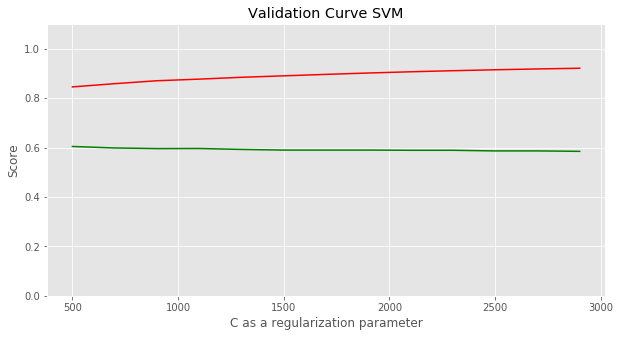

In [278]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)
plt.figure(figsize=(10,5))
plt.title("Validation Curve SVM")
plt.xlabel("C as a regularization parameter")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
#plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, train_scores_mean, label="Training score",
             color="r")
#plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.plot(param_range, test_scores_mean, label="Cross-validation score",color="g")
#plt.legend(loc="best")
#plt.xticks(param_range)
plt.show()